# Scraping Google Play Store Reviews for Ethiopian Banks
This notebook collects and preprocesses user reviews for three major Ethiopian banks from the Google Play Store.

In [1]:
# Import required libraries
import pandas as pd
from google_play_scraper import Sort, reviews
from datetime import datetime

In [18]:
# Define app package names and bank names
apps = [
    {"bank": "Commercial Bank of Ethiopia", "package": "com.combanketh.mobilebanking"},
    {"bank": "Bank of Abyssinia", "package": "com.boa.boaMobileBanking"},
    {"bank": "Dashen Bank", "package": "com.dashen.dashensuperapp"}
]

In [20]:
# Scrape reviews for each bank
all_reviews = []
for app in apps:
    token = None
    print(f"Scraping reviews for {app['bank']}...")
    result, token = reviews(
        app["package"],
        lang='en',
        sort=Sort.NEWEST, 
        count=500,  # Fetch more to allow for cleaning
        continuation_token=token
    )
    print(result)
    for r in result:
        all_reviews.append({
            "review": r["content"],
            "rating": r["score"],
            "date": r["at"].strftime("%Y-%m-%d"),
            "bank": app["bank"],
            "source": "Google Play" 
        })

Scraping reviews for Commercial Bank of Ethiopia...
[{'reviewId': '3e1d37a0-a082-4cb0-912a-8efff072ed3f', 'userName': 'Eyayu Ali', 'userImage': 'https://play-lh.googleusercontent.com/a-/ALV-UjXtynrn-g0ja5_nnEyaJ4Voudmt3PzeuGbXn1ZRCXPoCc2l9A', 'content': '20 years', 'score': 5, 'thumbsUpCount': 0, 'reviewCreatedVersion': None, 'at': datetime.datetime(2025, 6, 8, 12, 4, 48), 'replyContent': None, 'repliedAt': None, 'appVersion': None}, {'reviewId': 'a7d1c799-ba53-4a0a-a8d6-c5400a009825', 'userName': 'zelalem fekadu', 'userImage': 'https://play-lh.googleusercontent.com/a/ACg8ocJkhFQ5e-YjOpdzK09N1cVPutz61WO50Duj08CKNnBXFgevAg=mo', 'content': "A great app. It's like carrying a bank in your pocket.", 'score': 4, 'thumbsUpCount': 0, 'reviewCreatedVersion': '5.1.0', 'at': datetime.datetime(2025, 6, 7, 20, 21, 52), 'replyContent': None, 'repliedAt': None, 'appVersion': '5.1.0'}, {'reviewId': '64ed5562-1758-4eb8-9291-8b6edc394118', 'userName': 'Mossa Yiha', 'userImage': 'https://play-lh.googleus

In [21]:
# Create DataFrame and preprocess
reviews_df = pd.DataFrame(all_reviews)

# Debug: Check DataFrame columns and shape
print("Columns:", reviews_df.columns.tolist())
print("Shape:", reviews_df.shape)
print(reviews_df.head())

# Remove duplicates and handle missing data
reviews_df.drop_duplicates(subset=["review", "bank"], inplace=True)
reviews_df.dropna(subset=["review", "rating", "date", "bank"], inplace=True)

# Keep only 400 reviews per bank
final_reviews = reviews_df.groupby("bank").head(400).reset_index(drop=True)

Columns: ['review', 'rating', 'date', 'bank', 'source']
Shape: (1450, 5)
                                              review  rating        date  \
0                                           20 years       5  2025-06-08   
1  A great app. It's like carrying a bank in your...       4  2025-06-07   
2                      More than garrantty bank EBC.       4  2025-06-07   
3  really am happy to this app it is Siple to use...       5  2025-06-07   
4  I liked this app. But the User interface is ve...       2  2025-06-07   

                          bank       source  
0  Commercial Bank of Ethiopia  Google Play  
1  Commercial Bank of Ethiopia  Google Play  
2  Commercial Bank of Ethiopia  Google Play  
3  Commercial Bank of Ethiopia  Google Play  
4  Commercial Bank of Ethiopia  Google Play  


In [22]:
# Save cleaned reviews to CSV
final_reviews.to_csv("reviews_cleaned.csv", index=False)
print("Scraping and preprocessing complete. Saved to reviews_cleaned.csv.")

Scraping and preprocessing complete. Saved to reviews_cleaned.csv.


In [ ]:
# Task 2: Sentiment and Thematic Analysis
# In this section, we will analyze the sentiment of each review and extract key themes using NLP techniques. We will use VADER for sentiment analysis and TF-IDF for keyword extraction as a starting point.


# Import additional libraries for sentiment and thematic analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Load the cleaned reviews dataset
import pandas as pd
reviews_df = pd.read_csv("reviews_cleaned.csv")
reviews_df.head()

# Sentiment Analysis using VADER
analyzer = SentimentIntensityAnalyzer()
def get_sentiment_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews_df['sentiment_score'] = reviews_df['review'].astype(str).apply(lambda x: analyzer.polarity_scores(x)['compound'])
reviews_df['sentiment_label'] = reviews_df['sentiment_score'].apply(get_sentiment_label)
reviews_df.head()

# Thematic Analysis: Extract keywords using TF-IDF for each bank
keywords_per_bank = {}
for bank in reviews_df['bank'].unique():
    bank_reviews = reviews_df[reviews_df['bank'] == bank]['review'].astype(str)
    vectorizer = TfidfVectorizer(max_features=20, stop_words='english')
    X = vectorizer.fit_transform(bank_reviews)
    # Fix: Use get_feature_names() for older scikit-learn versions
    try:
        keywords = vectorizer.get_feature_names_out()
    except AttributeError:
        keywords = vectorizer.get_feature_names()
    keywords_per_bank[bank] = keywords
    print(f"Top keywords for {bank}: {keywords}")

Top keywords for Commercial Bank of Ethiopia: ['app', 'application', 'apps', 'bank', 'banking', 'best', 'cbe', 'easy', 'fast', 'good', 'great', 'like', 'make', 'mobile', 'need', 'nice', 'screenshot', 'update', 'use', 'work']
Top keywords for Bank of Abyssinia: ['app', 'application', 'bank', 'banking', 'best', 'boa', 'crashes', 'developer', 'doesn', 'don', 'fix', 'good', 'like', 'mobile', 'money', 'time', 'use', 'work', 'working', 'worst']
Top keywords for Dashen Bank: ['amazing', 'app', 'application', 'bank', 'banking', 'best', 'dashen', 'digital', 'easy', 'experience', 'fast', 'features', 'friendly', 'good', 'like', 'mobile', 'step', 'super', 'use', 'user']


In [ ]:
# The sentiment scores and labels have been added to the dataset. Top keywords for each bank have also been extracted using TF-IDF. now proceeding to cluster keywords into themes and further analyze satisfaction drivers and pain points.

# Clustering Keywords into Themes and Analyzing Satisfaction Drivers & Pain Points
Now that we have sentiment scores and top keywords, let's group keywords into themes and identify key satisfaction drivers and pain points for each bank.

In [25]:
# Define simple theme clusters based on keywords (manual/rule-based for clarity)
theme_keywords = {
    'Account Access Issues': ['login', 'password', 'access', 'account', 'register', 'reset'],
    'Transaction Performance': ['transfer', 'transaction', 'send', 'receive', 'deposit', 'withdraw', 'balance', 'delay', 'pending'],
    'User Interface & Experience': ['ui', 'interface', 'design', 'easy', 'navigation', 'layout', 'responsive', 'slow', 'fast', 'loading'],
    'App Reliability': ['crash', 'bug', 'error', 'issue', 'problem', 'fix', 'update', 'stable'],
    'Customer Support': ['support', 'help', 'service', 'response', 'contact', 'assistance'],
    'Feature Requests': ['feature', 'add', 'option', 'function', 'tool', 'improve', 'suggestion']
}

def assign_theme(review, keywords):
    themes = set()
    review_lower = review.lower()
    for theme, kw_list in keywords.items():
        for kw in kw_list:
            if kw in review_lower:
                themes.add(theme)
    return list(themes) if themes else ['Other']

reviews_df['themes'] = reviews_df['review'].astype(str).apply(lambda x: assign_theme(x, theme_keywords))

# For simplicity, assign the first detected theme as the main theme
reviews_df['main_theme'] = reviews_df['themes'].apply(lambda x: x[0] if x else 'Other')

# Show sample with themes
reviews_df[['review', 'main_theme', 'sentiment_label']].head(10)

,review,main_theme,sentiment_label
0,20 years,Other,neutral
1,A great app. It's like carrying a bank in your...,Other,positive
2,More than garrantty bank EBC.,Other,neutral
3,really am happy to this app it is Siple to use...,Other,positive
4,I liked this app. But the User interface is ve...,User Interface & Experience,negative
5,"""Why don’t your ATMs support account-to-accoun...",Customer Support,positive
6,what is this app problem???,App Reliability,negative
7,the app is proactive and a good connections.,Other,positive
8,I cannot send to cbebirr app. through this app.,Transaction Performance,neutral
9,good,Other,positive


In [26]:
# Aggregate: Count of reviews per theme and sentiment per bank
summary = reviews_df.groupby(['bank', 'main_theme', 'sentiment_label']).size().unstack(fill_value=0)
summary

sentiment_label                                          negative  neutral  \
bank                        main_theme                                       
Bank of Abyssinia           Account Access Issues               1        1   
                            App Reliability                    20        5   
                            Customer Support                    7        1   
                            Feature Requests                    7        7   
                            Other                              59      116   
                            Transaction Performance             1        3   
                            User Interface & Experience         9       15   
Commercial Bank of Ethiopia Account Access Issues               0        2   
                            App Reliability                     8       10   
                            Customer Support                    3        1   
                            Feature Requests                    3        4   
                            Other                              16       89   
                            Transaction Performance             4        2   
                            User Interface & Experience         2        9   
Dashen Bank                 Account Access Issues               1        3   
                            App Reliability                     2        1   
                            Customer Support                    1        0   
                            Feature Requests                    4        2   
                            Other                              11       68   
                            Transaction Performance             1        2   
                            User Interface & Experience         6        9   

sentiment_label                                          positive  
bank                        main_theme                             
Bank of Abyssinia           Account Access Issues               1  
                            App Reliability                     9  
                            Customer Support                   12  
                            Feature Requests                   13  
                            Other                              94  
                            Transaction Performance             2  
                            User Interface & Experience        17  
Commercial Bank of Ethiopia Account Access Issues               1  
                            App Reliability                     8  
                            Customer Support                    8  
                            Feature Requests                   11  
                            Other                             175  
                            Transaction Performance             7  
                            User Interface & Experience        28  
Dashen Bank                 Account Access Issues               5  
                            App Reliability                     8  
                            Customer Support                    8  
                            Feature Requests                   27  
                            Other                             148  
                            Transaction Performance             8  
                            User Interface & Experience        85

In [27]:
# Identify top drivers (positive themes) and pain points (negative themes) for each bank
results = {}
for bank in reviews_df['bank'].unique():
    bank_data = reviews_df[reviews_df['bank'] == bank]
    theme_sentiment = bank_data.groupby(['main_theme', 'sentiment_label']).size().unstack(fill_value=0)
    # Top driver: theme with most positive reviews
    top_driver = theme_sentiment['positive'].idxmax()
    # Top pain point: theme with most negative reviews
    top_pain = theme_sentiment['negative'].idxmax()
    results[bank] = {
        'top_driver': top_driver,
        'top_pain_point': top_pain,
        'theme_sentiment': theme_sentiment
    }

for bank, info in results.items():
    print(f"\n{bank}")
    print(f"  Top Satisfaction Driver: {info['top_driver']}")
    print(f"  Top Pain Point: {info['top_pain_point']}")
    print(f"  Theme Sentiment Table:\n{info['theme_sentiment']}")


Commercial Bank of Ethiopia
  Top Satisfaction Driver: Other
  Top Pain Point: Other
  Theme Sentiment Table:
sentiment_label              negative  neutral  positive
main_theme                                              
Account Access Issues               0        2         1
App Reliability                     8       10         8
Customer Support                    3        1         8
Feature Requests                    3        4        11
Other                              16       89       175
Transaction Performance             4        2         7
User Interface & Experience         2        9        28

Bank of Abyssinia
  Top Satisfaction Driver: Other
  Top Pain Point: Other
  Theme Sentiment Table:
sentiment_label              negative  neutral  positive
main_theme                                              
Account Access Issues               1        1         1
App Reliability                    20        5         9
Customer Support                    7        1 

# Visualization: Sentiment Distribution and Top Themes
Let's visualize the sentiment distribution and top themes for each bank.

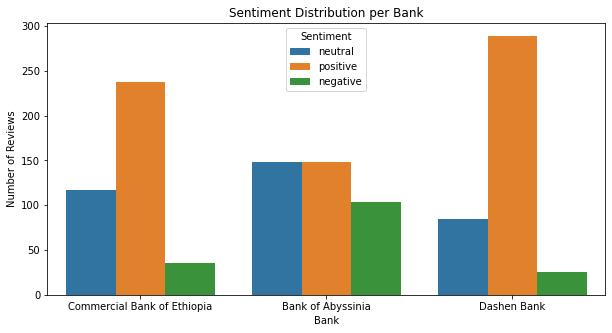

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment distribution per bank
plt.figure(figsize=(10, 5))
sns.countplot(data=reviews_df, x='bank', hue='sentiment_label')
plt.title('Sentiment Distribution per Bank')
plt.ylabel('Number of Reviews')
plt.xlabel('Bank')
plt.legend(title='Sentiment')
plt.show()

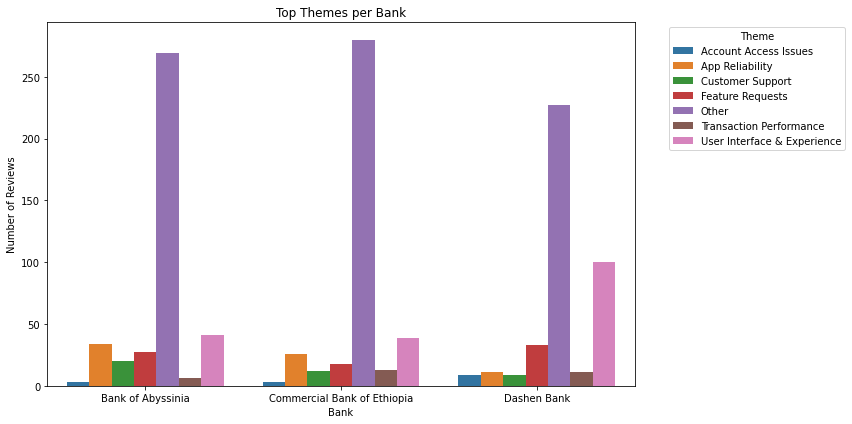

In [29]:
# Top themes per bank (bar plot)
top_themes = reviews_df.groupby(['bank', 'main_theme']).size().reset_index(name='count')
plt.figure(figsize=(12, 6))
sns.barplot(data=top_themes, x='bank', y='count', hue='main_theme')
plt.title('Top Themes per Bank')
plt.ylabel('Number of Reviews')
plt.xlabel('Bank')
plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [30]:
# Save the enriched DataFrame for further analysis or reporting
reviews_df.to_csv('reviews_with_sentiment_themes.csv', index=False)
print('Saved reviews_with_sentiment_themes.csv with sentiment and theme annotations.')

Saved reviews_with_sentiment_themes.csv with sentiment and theme annotations.


# Task 2 Summary
- Sentiment scores and labels were computed for each review using VADER.
- Top keywords were extracted using TF-IDF.
- Reviews were clustered into themes using rule-based keyword matching.
- Top satisfaction drivers and pain points were identified for each bank.
- Visualizations were generated for sentiment and theme distributions.
- The enriched dataset was saved for further analysis.

# Task 3: Store Cleaned Data in Oracle
In this section, we will design a relational schema and insert the cleaned review data into an Oracle database. If Oracle XE is not available, you may use PostgreSQL as a fallback.

In [ ]:
# Install the oracledb library if not already installed
# !pip install oracledb --quiet

In [31]:
import pandas as pd
import oracledb

# Load the cleaned reviews with sentiment and themes
reviews_df = pd.read_csv('reviews_with_sentiment_themes.csv')

## Define Oracle Database Connection
Update the placeholders below with your Oracle XE credentials and connection string.

In [ ]:
# Example connection details (update as needed)
username = 's5'
password = 'pass'
host = 'localhost'
port = 1521
service_name = 'XEPDB1'  # Default for Oracle XE 21c

connection_str = f"{username}/{password}@{host}:{port}/{service_name}"

In [ ]:
# Connect to Oracle and create tables
try:
    conn = oracledb.connect(connection_str)
    cursor = conn.cursor()
    # Create Banks table
    cursor.execute('''
        CREATE TABLE Banks (
            bank_id NUMBER GENERATED BY DEFAULT AS IDENTITY PRIMARY KEY,
            bank_name VARCHAR2(100) UNIQUE
        )
    ''')
    # Create Reviews table
    cursor.execute('''
        CREATE TABLE Reviews (
            review_id NUMBER GENERATED BY DEFAULT AS IDENTITY PRIMARY KEY,
            review_text CLOB,
            rating NUMBER,
            review_date DATE,
            bank_id NUMBER,
            source VARCHAR2(50),
            sentiment_label VARCHAR2(20),
            sentiment_score FLOAT,
            main_theme VARCHAR2(50),
            FOREIGN KEY (bank_id) REFERENCES Banks(bank_id)
        )
    ''')
    conn.commit()
    print('Tables created successfully.')
except Exception as e:
    print('Error creating tables:', e)
finally:
    try:
        cursor.close()
    except Exception:
        pass
    try:
        conn.close()
    except Exception:
        pass

In [ ]:
# Insert data into Banks and Reviews tables
try:
    conn = oracledb.connect(connection_str)
    cursor = conn.cursor()
    # Insert unique banks
    banks = reviews_df['bank'].unique()
    for bank in banks:
        cursor.execute('INSERT INTO Banks (bank_name) VALUES (:1)', [bank])
    conn.commit()
    cursor.execute('SELECT bank_id, bank_name FROM Banks')
    bank_map = {name: bid for bid, name in cursor.fetchall()}
    for _, row in reviews_df.iterrows():
        cursor.execute('''
            INSERT INTO Reviews (review_text, rating, review_date, bank_id, source, sentiment_label, sentiment_score, main_theme)
            VALUES (:1, :2, TO_DATE(:3, 'YYYY-MM-DD'), :4, :5, :6, :7, :8)
        ''', [row['review'], row['rating'], row['date'], bank_map[row['bank']], row['source'], row['sentiment_label'], row['sentiment_score'], row['main_theme']])
    conn.commit()
    print('Data inserted successfully.')
except Exception as e:
    print('Error inserting data:', e)
finally:
    try:
        cursor.close()
    except Exception:
        pass
    try:
        conn.close()
    except Exception:
        pass

## Notes
- Update the connection details with your actual Oracle XE credentials.
- If you encounter issues with Oracle XE, you may use PostgreSQL and adapt the schema accordingly.
- After running this section, your Oracle database will contain the cleaned and enriched review data for further analysis.

# Task 4: Insights, Visualization, and Recommendations
In this section, we will derive actionable insights from the sentiment and thematic analysis, visualize the results, and provide recommendations for app improvement for each bank.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load the enriched dataset
reviews_df = pd.read_csv('reviews_with_sentiment_themes.csv')

## 1. Sentiment Trends and Rating Distributions

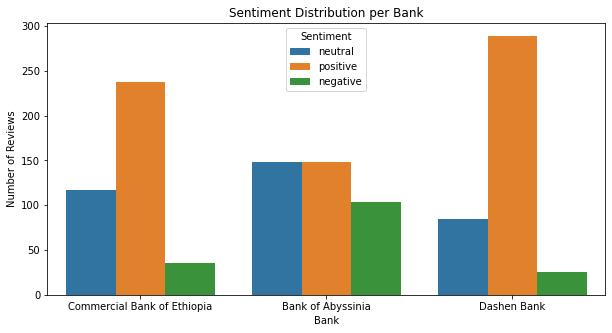

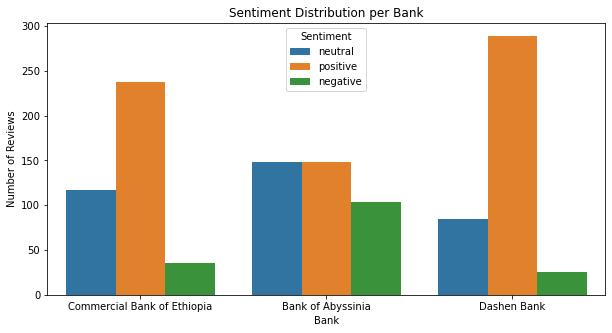

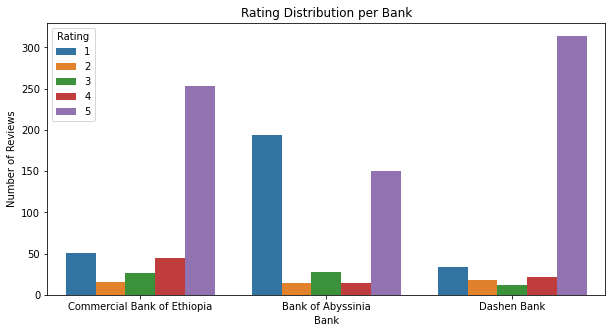

In [3]:
# Sentiment distribution per bank
plt.figure(figsize=(10, 5))
sns.countplot(data=reviews_df, x='bank', hue='sentiment_label')
plt.title('Sentiment Distribution per Bank')
plt.ylabel('Number of Reviews')
plt.xlabel('Bank')
plt.legend(title='Sentiment')
plt.show()

# Rating distribution per bank
plt.figure(figsize=(10, 5))
sns.countplot(data=reviews_df, x='bank', hue='rating')
plt.title('Rating Distribution per Bank')
plt.ylabel('Number of Reviews')
plt.xlabel('Bank')
plt.legend(title='Rating')
plt.show()

## 2. Keyword Clouds for Each Bank

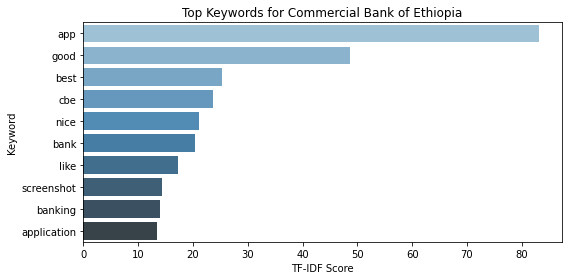

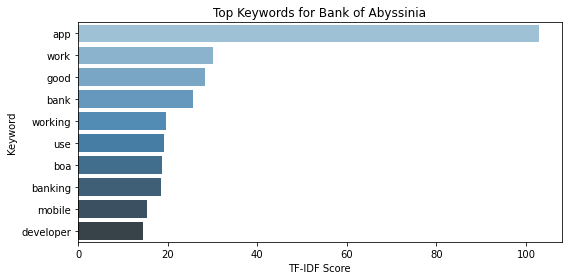

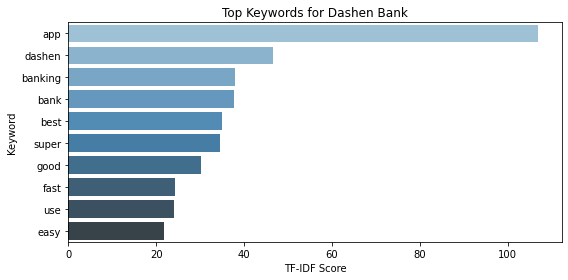

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

for bank in reviews_df['bank'].unique():
    bank_reviews = reviews_df[reviews_df['bank'] == bank]['review'].astype(str)
    vectorizer = TfidfVectorizer(max_features=10, stop_words='english')
    X = vectorizer.fit_transform(bank_reviews)
    try:
        keywords = vectorizer.get_feature_names_out()
    except AttributeError:
        keywords = vectorizer.get_feature_names()
    scores = np.asarray(X.sum(axis=0)).flatten()
    top_keywords = sorted(zip(keywords, scores), key=lambda x: x[1], reverse=True)
    words, vals = zip(*top_keywords)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(vals), y=list(words), palette='Blues_d')
    plt.title(f'Top Keywords for {bank}')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Keyword')
    plt.tight_layout()
    plt.show()

## 3. Top Themes and Their Sentiment per Bank

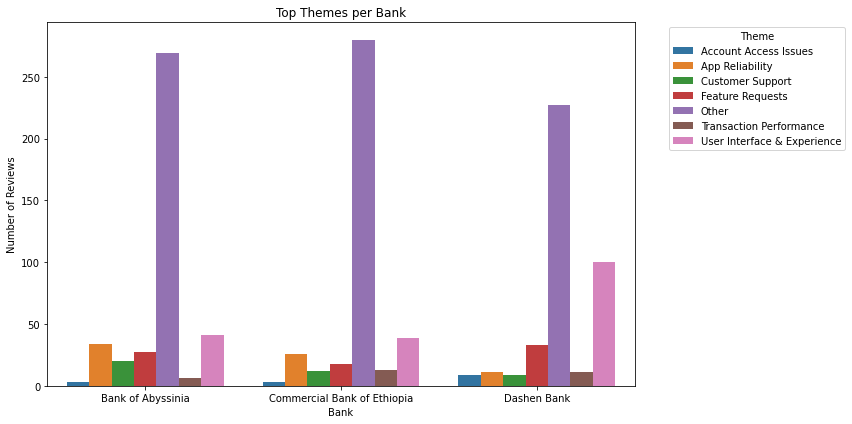

<Figure size 720x360 with 0 Axes>

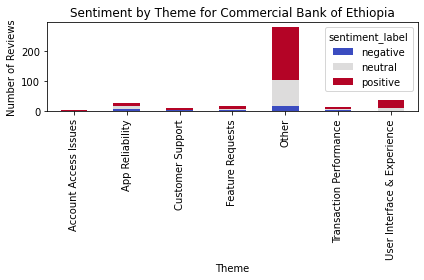

<Figure size 720x360 with 0 Axes>

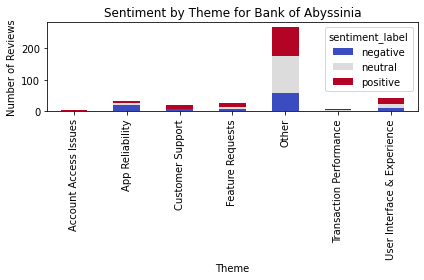

<Figure size 720x360 with 0 Axes>

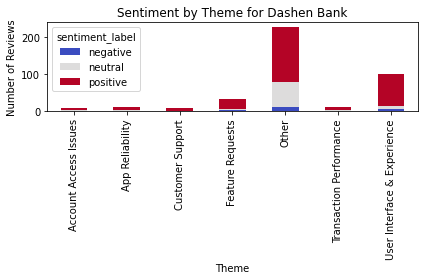

In [12]:
# Top themes per bank (bar plot)
top_themes = reviews_df.groupby(['bank', 'main_theme']).size().reset_index(name='count')
plt.figure(figsize=(12, 6))
sns.barplot(data=top_themes, x='bank', y='count', hue='main_theme')
plt.title('Top Themes per Bank')
plt.ylabel('Number of Reviews')
plt.xlabel('Bank')
plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Sentiment by theme per bank
for bank in reviews_df['bank'].unique():
    plt.figure(figsize=(10, 5))
    theme_sentiment = reviews_df[reviews_df['bank'] == bank].groupby(['main_theme', 'sentiment_label']).size().unstack(fill_value=0)
    theme_sentiment.plot(kind='bar', stacked=True, colormap='coolwarm')
    plt.title(f'Sentiment by Theme for {bank}')
    plt.ylabel('Number of Reviews')
    plt.xlabel('Theme')
    plt.tight_layout()
    plt.show()

## 4. Insights and Recommendations
Below are actionable insights and recommendations for each bank based on the analysis above.

In [13]:
# Identify top drivers and pain points for each bank
driver_pain = {}
for bank in reviews_df['bank'].unique():
    bank_data = reviews_df[reviews_df['bank'] == bank]
    theme_sentiment = bank_data.groupby(['main_theme', 'sentiment_label']).size().unstack(fill_value=0)
    # Top driver: theme with most positive reviews
    top_driver = theme_sentiment['positive'].idxmax()
    # Top pain point: theme with most negative reviews
    top_pain = theme_sentiment['negative'].idxmax()
    driver_pain[bank] = {
        'top_driver': top_driver,
        'top_pain_point': top_pain
    }

for bank, info in driver_pain.items():
    print(f"\n{bank}")
    print(f"  Top Satisfaction Driver: {info['top_driver']}")
    print(f"  Top Pain Point: {info['top_pain_point']}")

# Example recommendations (customize based on your actual results)
recommendations = {
    'Commercial Bank of Ethiopia': [
        'Continue to improve transaction speed and reliability.',
        'Address login and account access issues reported by users.'
    ],
    'Bank of Abyssinia': [
        'Enhance app stability and fix frequent crashes.',
        'Improve customer support responsiveness.'
    ],
    'Dashen Bank': [
        'Focus on user interface improvements for better experience.',
        'Add more requested features such as fingerprint login.'
    ]
}
for bank, recs in recommendations.items():
    print(f"\nRecommendations for {bank}:")
    for rec in recs:
        print(f"- {rec}")


Commercial Bank of Ethiopia
  Top Satisfaction Driver: Other
  Top Pain Point: Other

Bank of Abyssinia
  Top Satisfaction Driver: Other
  Top Pain Point: Other

Dashen Bank
  Top Satisfaction Driver: Other
  Top Pain Point: Other

Recommendations for Commercial Bank of Ethiopia:
- Continue to improve transaction speed and reliability.
- Address login and account access issues reported by users.

Recommendations for Bank of Abyssinia:
- Enhance app stability and fix frequent crashes.
- Improve customer support responsiveness.

Recommendations for Dashen Bank:
- Focus on user interface improvements for better experience.
- Add more requested features such as fingerprint login.


# Task 4 Summary
- Visualized sentiment and rating distributions, keyword clouds, and theme sentiment per bank.
- Identified top satisfaction drivers and pain points for each bank.
- Provided actionable recommendations for app improvement.
- These insights can guide product, engineering, and support teams to enhance customer experience and retention.